# Table of Contents
* [Packages and Imports](#PackagesandImports)   
* [File Access and Dataframe Creation](#FileAccessandDataframeCreation)
* [Display of Dataframes](#DisplayofDataframes)
    * [Dataframes Used for Stat Computations](#DataframesUsedforStatComputations)
    * [Dataframes Used for Plotting](#DataframesUsedforPlotting)
* [Functions](#Functions)
    * [Descriptive/Calculation Functions](#Descriptive/CalculationFunctions)
    * [Datetime Range Functions](#DateRangeFunctions)
    * [Dataframe Manipulation Functions](#DataframeManipulationFunctions)
    * [Plot and Figure Functions](#PlotAndFigureFunctions)
* [Stats](#Stats)
    * [Sample of One Hour Grid (0Z)](#Sample)
    * [Full Hour (0Z)](#FullHour)
* [Figures for Sample and Full Hour](#Figures)
    * [Histograms](#Histograms)
    * [Scatter Plots](#Scatter)
* [Data and Visualization for Larger Datasets](#Larger Datasets)
* [Formulas](#Formulas)
   

# Packages and Imports<a class="anchor" id="PackagesandImports"></a>

In [4]:
#import packages to create dataframe, perform stats and plot figures
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
from scipy import stats
import math
import random  
import datetime as dt
import plotly.graph_objects as go

# File Access and Dataframe Creation<a class="anchor" id="FileAccessandDataframeCreation"></a>

In [64]:
#read text file and create dataframe
#with individual columns for the i and j cord 
#as well as flash counts for each instrument
df = pd.read_csv('eni_glm_out.txt',
        names=['i coords','j coords','ENI flshes','GLM flshes'], delimiter='\s+')

#subset datafame so flash counts can be used for stats
#Only include flash counts for instruments
df_flsh = df[['ENI flshes', 'GLM flshes']]

#create dataframe with count of instances for each flash coordinate
df_flshuniquecount = df_flsh.groupby(['ENI flshes', 'GLM flshes']).size()
df_flshinstances = df_flshuniquecount.to_frame(name = 'Instances').reset_index()

#create dataframe with sample of entries 2-4
df_flsh234 = df_flsh[2:4]

# Display of Dataframes<a class="anchor" id="DisplayofDataframes"></a>

## Dataframes used for Stat Computations<a class="anchor" id="DataframesUsedforStatComputations"></a>

In [73]:
#print original dataframe containing all information given 
#in text file (remove hastag symbol below to display dataframe)

#df

In [74]:
#print subset dataframe with columns for flash counts only
#(remove hastag symbol below to display dataframe)

#df_flsh

In [75]:
#print dataframe with sample of entries 2-3
#(remove hastag symbol below to display dataframe)

#df_flsh234

## Dataframe used for plotting<a class="anchor" id="DataframesUsedforPlotting"></a>

In [76]:
#print dataframe with count of number of instances for flashes coords.
#intervals may be assigned distinct colors to create color-coded scatter plot
#(remove hastag symbol below to display dataframe)

#df_flshinstances['ENI flshes'].loc[df_flshinstances['ENI flshes'] <=75]
#df_flshinstances

# Functions<a class="anchor" id="Functions"></a>

## Descriptive/Calculation Functions<a class="anchor" id="Descriptive/CalculationFunctions"></a>

In [120]:
#prints individual stats from flash counts
#where dframe is the name of the entire dataframe 
# dfname1 & dfname2 refer to dataframe with column labels i.e dataframename['column name']
#in typical instances 'column label' will be 'ENI flshes' or 'GLM flshes'

#get sum of a flashes for an instrument
def getsum(dframe):
    return np.sum(dframe)

#get mean of all flashes for an instrument
def getmean(dframe):
    return np.mean(dframe)

#def getvar(dfname):
#    mn = getmean(dfname)
#    print(len(dfname))
#    return (sum((dfname-mn)**2))/len(dfname)-1
    #return dfname.var(ddof=0)

#get mean of the sample for an instrument
def getstd(dframe):
    return np.std(dframe, ddof=1)

#get the difference of the means between instruments
def getdiffofmean(dfname1, dfname2):
    mean1 = getmean(dfname1)
    mean2 = getmean(dfname2)
    return mean1 - mean2

#get the mean absolute difference between instruments
def getmad(dfname1, dfname2):
    
    diff=0
    for i, j in zip(dfname1, dfname2):
        diff+=abs(i-j)
    
    if (dfname1.shape[0] == dfname2.shape[0]):
        MAD=abs(diff/dfname1.shape[0])        
        return MAD
    else:
        return -1

#get the root mean square difference between instruments
def getrmsd(dfname1, dfname2):
    
    diff=0
    for i, j in zip(dfname1, dfname2):
        diff+=np.square(i-j)

    if (dfname1.shape[0] == dfname2.shape[0]):
        RMSD=np.sqrt((1.0/dfname1.shape[0])*diff)
        return RMSD
    else:
        return -1

In [78]:
#prints all basic stats from flash counts
#standard deviation was removed from 'describe' function
#will be added individually to account for ddof (see formula section for more info.)
#here dframe is the name of the entire dataframe while column1 and column2 refer to 
#soley the column labels as a string NOT including the dataframe name 

def printallstats(dframe, column1, column2):
    print(dframe.describe().drop("std"))
    print("\nSum of Flashes:\n" + str(getsum(dframe)))
    print("\nMean of Flashes:\n" + str(getmean(dframe)))
    print("\nStandard Deviation:\n" + str(getstd(dframe)))
    print("\nDifference of Means:\n" + str(getdiffofmean(dframe[column1], dframe[column2])))
    print("\nMean Absolute Difference:\n" + str(getmad(dframe[column1], dframe[column2])))
    print("\nRoot Mean Square Difference:\n" + str(getrmsd(dframe[column1], dframe[column2])))
    

In [118]:
#Return variable calculations for regression line 
#These function are automated within various plotting functions
#However they can be used separately. In that case X and Y refer
#to the X and Y variables respectively. If using dataframe values
#be sure to include the dataframe name (e.g dataframename['X variable'])

#pearson's correlation
def getrcoor(X, Y):
    x = X - getmean(X)
    y = Y - getmean(Y)
    xysum = getsum(x*y)
    
    x2sum = getsum(x**2)
    y2sum = getsum(y**2)
    
    return (xysum)/(np.sqrt(x2sum*y2sum))

#slope of regression line
def getslope(X, Y):
    r = getrcoor(X, Y)
    stdX = getstd(X)
    stdY = getstd(Y)
    
    return r*stdX/stdY

#y intercept of regression line
def getintercept(X, Y):
    m = getslope(X,Y)
    meanX = getmean(X)
    meanY = getmean(Y)
    
    return meanY - m*meanX
    

In [80]:
#### to be worked on later

def gettpvalues(dframe):
    
    t, p = stats.ttest_ind(dframe['ENI flshes'], dframe['GLM flshes'], axis=0, equal_var=False, nan_policy='raise')
    
    return t, p
    print(t)
    print(p)    

In [81]:
#to be worked on later
def getmultitpvals(dfname, dates):
    
    tlst=[]
    plst=[]
    
    for x in dfname:
        ttest, ptest = gettpvalues(x)
        tlst.append(ttest)
        plst.append(ptest)
        
    df_ptvals = pd.DataFrame(list(zip(dates, tlst, plst)), 
               columns =['Date', 't Value', 'p Value'])
    return df_ptvals
        
        

## Datetime Range Functions<a class="anchor" id="DateRangeFunctions"></a>

In [162]:
def getperiodrange(multibool):
    
    #Create datetime dictionary to hold datetime keys(time measurement) and their values
    #dtdict1={'start year':"", "start month":"", 'start day':'', 'start hour':''}
    #Also create a delta dictionary to keep track the increment in which date strings
    #will be output between the start and end of the period
    singdict={'year (yyyy)':"", "month (mm)":"", 'day (dd)':'', 'hour (hh)':''}
    dtdict1={'year (yyyy)': "", "month (mm)": "", 'day (dd)': "", 'hour (hh)': ""}
    dtdict2={'year (yyyy)':"", "month (mm)":"", 'day (dd)':'', 'hour (hh)':''}
    deldict = {'D': 0, 'H': 0 }
    
    if(multibool == 'n'):
        for key in dtdict1:
            singdict1[key] = int(input('Enter the ' + key + ': '))
            td = 0
            return singdict, singdict, td
    elif (multibool == 'y'):
        #Collect user input as to the start and end of the duration for which
        #the list of datetime string should be generated
        for key in dtdict1:
            dtdict1[key] = int(input('Enter the ' + key + ': '))
        for key in dtdict2:
            dtdict2[key] = int(input('Enter the ' + key + ': '))
        
        date1 = dt.datetime(dtdict1['year (yyyy)'], dtdict1['month (mm)'], dtdict1['day (dd)'], dtdict1['hour (hh)'])    
        date2 = dt.datetime(dtdict2['year (yyyy)'], dtdict2['month (mm)'], dtdict2['day (dd)'], dtdict2['hour (hh)'])
        deltsteptype = str(input("How often would like like data plotted? (Step Options: 'D'=day(s) or 'H'=hour(s))"))
        deldict[deltsteptype] = int(input("What is the value of time step? (Enter '1' as default for 1 " +
                                      "day or 1 hour increments) "))
        td = timedelta(days=deldict['D'], hours=deldict['H'])
        
        return date1, date2, td

In [140]:
#Get user input datetime objects for desired range
#Input is then given to function so that corresponding plots 
#and/or statistics can be done

def generatedatesbyrange():

    #create empty list to append constructed datetime strings for dataframe indexing
    datetimelst = []

    #Give instructions on user input.
    print("The following generates a list of datetime strings based on user input range.\n")
    print("Note all input should be entered as a 2 digit integer (i.e. 1 = 01, 10 = 10) except " +
         "the year which should be four digits (yyyy) and the delta time step type which should be a single " +
         "capital letter.\n\n")
    
    multbool = str(input("Would you like to use one or more datetime periods? [y/n]"))
    date_1, date_2, tdel = getperiodrange(multbool)
     
    if (cmp(date_1,date_2) == 0) and tdel == 0:
        datetimelst.append(str(date_1['year (yyyy)']) + str(date_1['month (mm)']) + str(date_1['day (dd)']) + 
                            str(date_1['hour (hr)']))
        return datetimelst, tdel
    elif (cmp(date_1,date_2) != 0) and tdel != 0:
        date = date_1
        while True:
            datetimelst.append(date.strftime('%Y%m%d%H'))
            date = date + td
            if(date>date_2):
                break
        return datetimelst, td
    else:
        raise ValueError()

In [117]:
#generate a sorted list of strings for random days for a given year,
#month and hour
def generaterandomdays():
    
    #create empty array for datetime strings
    datetime = []
   
    date_1, date_2, tdel = getperiodrange('y')
    date = date_1
    while True:
            datetime.append(date.strftime('%Y%m%d%H'))
            date = date + tdel
            if(date>date_2):
                break
    maxvals = len(datetime)
    numofvals = input("You have " + i + "datetime values within the range. How many random datetimes " +
                     "would you like?")
    if numvals<= i:
        #generate a sorted list of n (num of vals) random numbers 
        day = sorted(random.sample(range(1, maxrange), numofvals))
    
        #fill datetime array with yyyymmddhh values
        for j in day:
        
        datetimelist.append(datetime[j])
        #print(datetime[i])    

        #return the list of randomly generated datetime strings
        return datetime
    else:
        raise ValueError('Number of values not in range.')

## Dataframe Manipulation Functions<a class="anchor" id="DataframeManipulationFunctions"></a>

In [17]:
#generate a list of dateframes with each dataframe
#corresponding to data from a different date. 
def generatedtdframes(dfname, dates):
    
    dfstore = []
    
    #if dates == 'ALL':
    #    days_to_set = set()
    #    days_to_list = list(days_to_set)
    #    dates == sorted(days_to_list)
    #    print dates
    #else:
    #    pass
    
    for x in dates:
        
        #print(x)
        dfstore.append(dfname.loc[dfname['datetime'] == int(x)]) 
        
    return dfstore

In [18]:
#The input is a list of dataframe corresponding to a list of data 
#(must correspond to the same indices). The function create a new list
#of dataframe where each data keeps data rows where neitherthe ENI and GLM flash
#count is zero. If as a result of this a dataframe is empty (i.e either all of both
#ENI and GLM flashes are zero) the function removes that dataframe along with the date
#The return is a new list of dataframes and dates where the dataframe and dates only contain
#days where neither instrument has a zero flash count
def getnonzeros(dataframe, dates):
    
    nonzero_dfs = []
    nonzero_dts = []
    
    for dfrm, dtime in zip(dataframe, dates):
        
        nonzerovalues = dfrm.loc[dfrm['ENI flshes'] != 0].loc[dfrm['GLM flshes'] != 0]
        
        if len(nonzerovalues) > 0:
            nonzero_dfs.append(nonzerovalues)
            nonzero_dts.append(dtime)
        else:
            pass
            
        
    return nonzero_dfs, nonzero_dts
    

## Plot and Figure Functions<a class="anchor" id="PlotAndFigureFunctions"></a>

In [14]:
#This function obtains the limits for use in scatter plot figure.
#The input is a list of dataframes. The function goes through each
#and gets the maximum values of flahses for both instruments then 
#compares the two. The highest values is then compared to the overall
#highest seen at that point (the first dataframe is compared to max of zero).
#If it is higher a new maximum is set if not the function goes to the next dataframe.
#One all dataframes values have been compared the function returns the highest flash count
#to be used as the range maximum.

def getlimit(dataframe):
    
    hgh=0 #set initial high between instruments as 0
    maxval=0 #set initial overall highest flash as zero
    
    #iterate through each dataframe in the list
    for dframe in dataframe:
    
        
        #obtain highest values for each instrument then take the squareroot
        xmax = (dframe['ENI flshes'].nlargest(1)).iloc[0]
        xmax_sqrt = round(np.sqrt((dframe['ENI flshes'].nlargest(1)).iloc[0]))
        ymax = (dframe['GLM flshes'].nlargest(1)).iloc[0]
        ymax_sqrt = round(np.sqrt((dframe['GLM flshes'].nlargest(1)).iloc[0]))
    
        #print(xmax)
        #print(xmax_sqrt)
        #print(ymax)
        #print(ymax_sqrt)
    
        #get the highest flash count value between the two instruments 
        hghst = max(xmax_sqrt,ymax_sqrt)
        #print("hghst " + str(hghst))
    
        #compare highest value between instruments to the overall
        #highest value. If it is higher set it as the new max.
        if hghst > maxval:
            maxval = hghst
        else:
            pass
    
    print(maxval)
    
    #find the highest value 5 that will serve as limit max 
    #limit max will include all flash value without any truncation
    divisor = 5

    remaindr = maxval%5

    if remaindr != 0:
        smmnd=(5-(maxval%5))
        lim = maxval + smmnd    
    else:
        lim = maxval + 5
        
    return lim
    

In [15]:
#This function obtains the limits for use in scatter plot figure.
#The input is a list of dataframes. The function goes through each
#and gets the maximum values of flahses for both instruments then 
#compares the two. The highest values is then compared to the overall
#highest seen at that point (the first dataframe is compared to max of zero).
#If it is higher a new maximum is set if not the function goes to the next dataframe.
#One all dataframes values have been compared the function returns the highest flash count
#to be used as the range maximum.

def getnonsqrtlimit(dataframe):
    
    hgh=0 #set initial high between instruments as 0
    maxval=0 #set initial overall highest flash as zero
    
    #iterate through each dataframe in the list
    for dframe in dataframe:
    
        
        #obtain highest values for each instrument then take the squareroot
        xmax = (dframe['ENI flshes'].nlargest(1)).iloc[0]
        ymax = (dframe['GLM flshes'].nlargest(1)).iloc[0]
    
        #print(xmax)
        #print(xmax_sqrt)
        #print(ymax)
        #print(ymax_sqrt)
    
        #get the highest flash count value between the two instruments 
        hghst = max(xmax,ymax)
        #print("hghst " + str(hghst))
    
        #compare highest value between instruments to the overall
        #highest value. If it is higher set it as the new max.
        if hghst > maxval:
            maxval = hghst
        else:
            pass
    
    print(maxval)
    
    #find the highest value 5 that will serve as limit max 
    #limit max will include all flash value without any truncation

    remaindr = maxval%25

    if remaindr != 0:
        smmnd=(25-(maxval%25))
        lim = maxval + smmnd    
    else:
        lim = maxval + 25
        
    return lim
    

In [16]:
#Input is a maxlimit (i.e that could be used as an axes maximum for a plot).
#Then based on that maxvalue the function sets chooses a step or intervals
#that the corresponding plot with the axes limit should use to be clear and
#readable.
def getinterval(rangemax):
    
    if rangemax <= 10:
        step = 1
    elif rangemax <= 20:
        step = 2.5
    elif rangemax <= 40:
        step = 5
    elif rangemax <= 80:
        step = 10
    elif rangemax <= 160:
        step = 20
    elif rangemax <= 200:
        step = 25
    elif rangemax <= 500:
        step = 50
    else:
        step = 100
     
    return step

In [19]:
# To create a Histogram

def makehistogram(dfname, dfcolname, binnum, size, minxlim, maxxlim, minylim, maxylim, instr, dtime):
    
    
    fig = plt.figure(figsize=(size,size))
    fig.suptitle(instr +  " Normalized Flash Frequency Count for " + dtime)
    
    weight = [1/(dfcolname.count())] * dfname.shape[0]
    plt.hist(x = dfcolname, density= False, edgecolor='black', bins = binnum, weights = weight)
    
    #  weights = weight
    
    plt.xlabel("Number of Flashes per Grid Box", fontsize=15)
    plt.ylabel("Frequency of Flashes", fontsize=15)
    plt.xlim([minxlim, maxxlim])
    plt.ylim([minylim, maxylim])
    
    
    
    #plt.savefig(name, dpi = 300, bbox_inches='tight')
    
    plt.show()
    

In [20]:
# To create stacked Histograms

def makestackedhistogram(dfname, col1, col2, binnum, size, xlim, maxy, yinter, name):
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(size,size), sharex=True, sharey=False)
    fig.subplots_adjust(hspace=0)
    fig.suptitle('ENI (Top) and GLM (Bottom) Normalized Flash Frequency Count for 20190701 00-01z', y=.9)
    #ax1.set_title("ENI Data")
    #ax2.set_title("GLM Data")
    
    weight1 = [1/(dfname[col1].count())] * dfname.shape[0]
    weight2 = [1/(dfname[col2].count())] * dfname.shape[0]
    
    #plot histograms for each instrument
    ax1.hist(x = dfname[col1] , density=False, edgecolor='black', bins=binnum, weights=weight1)
    ax2.hist(x = dfname[col2] , density=False, edgecolor='black', bins=binnum, weights=weight2)
    
    #set labels for x axis (shared) and y axes
    plt.xlabel("Number of Flashes per Grid Box", fontsize=15)
    ax1.set_ylabel("ENI Normalized Relative Frequency", fontsize=15)
    ax2.set_ylabel("GLM Normalized Relative Frequency", fontsize=15)
    
    #set range and intervals (y axes only) for axes
    plt.xlim([xlim[0], xlim[1]])
    ax1.set_yticks(np.arange(0.0, maxy, yinter))
    ax1.set_ylim(0.0, maxy)
    ax2.set_yticks(np.arange(0.0, maxy, yinter))
    ax2.set_ylim(0.0, maxy)
    
    #save as png or show in notebook 
    if name != "-":
        plt.savefig(name, dpi = 300, bbox_inches='tight')
    else:
        plt.show()

In [21]:
# To create a scatterplot of sample data

def makescattersample(dfname1, dfname2, regress, minlim, maxlim):
    
    #create figure
    fig = plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(1, 1, 1)
    
    #Plot scatter figure
    plt.scatter(x = dfname1, y = dfname2, marker = ".", s = 100, 
                    color = "black", label=df_flsh.shape[0])
            
    #Plot regression line if true
    if regress == True:
        m = getslope(dfname1, dfname2)
        b = getintercept(dfname1, dfname2)
        plt.plot(dfname1, b + m * dfname1, '-')
        
    #Set other parameters
    plt.title("ENI vs GLM Scatter Plot of Sample Data", fontsize=15)
    plt.xlabel("ENI Flash Count", fontsize=15)
    plt.ylabel("GLM Flash Count", fontsize=15)
    plt.xlim([minlim, maxlim])
    plt.ylim([minlim, maxlim])
    plt.xscale('linear')
    plt.yscale('linear')
    
    #create legend with number of data points
    plt.legend(title="Number of Data Points")
    
    plt.show()
        

In [22]:
# To create a scatterplot (w/ or w/out regression line and color-coding)

def makescatter(dfname1, dfname2, minlim, maxlim, name):
    
    #create figure
    fig = plt.figure(figsize=(15,15))
    #ax = fig.add_subplot(1, 1, 1)
    
    #Plot individual markers with or without interval color coding
    #if colorcode == True:
    #    for i, j, c in zip(dfname3['ENI flshes'], dfname3['GLM flshes'], dfname3['C']): 
    #         plt.scatter(x = np.sqrt(i), y = np.sqrt(j), marker=".", s = 13, color = c) 
    #else:
    plt.scatter(x = np.sqrt(dfname1), y = np.sqrt(dfname2), marker = ".", s = 13, 
                color = "black", label=df_flsh.shape[0])
    
    if max(dfname1) != 0 and max(dfname2) != 0:
        #Plot regression line
        m = getslope(np.sqrt(dfname1), np.sqrt(dfname2))
        b = getintercept(np.sqrt(dfname1), np.sqrt(dfname2))
        plt.plot(np.sqrt(dfname1), b + m * np.sqrt(dfname1), '-')
        
        eq = 'y=' + str(round(m,2)) + 'x+' + str(round(b,2))    
        plt.text(np.sqrt(dfname1.nlargest(4)).iloc[-1], m*np.sqrt(dfname1.nlargest(4)).iloc[-1]+b+1,
                 eq, fontsize=12, rotation=math.degrees(math.atan(m)))
       
    
    #np.sqrt(df_flsh['ENI flshes'].nlargest(3)).iloc[-1]
        
    #Set other parameters
    plt.title("ENI vs GLM Scatter Plot", fontsize=15)
    plt.xlabel("Square Root of ENI Flash Count", fontsize=15)
    plt.ylabel("Square Root of GLM Flash Count", fontsize=15)
    plt.xlim([minlim, maxlim])
    plt.ylim([minlim, maxlim])
    plt.xscale('linear')
    plt.yscale('linear')
    
    #create legend with number of data points
    plt.legend(title="Number of Data Points")
    
    
    plt.savefig(name, dpi = 300, bbox_inches='tight')
    
    plt.show()
        

In [23]:
# To create a scatterplot of sample data

def makemultiplescatter(dfname, dates, size, maxlim, name):
    
    fig, axs = plt.subplots(2, 2, figsize=(size,size),sharex=True, sharey=True)
    fig.subplots_adjust()
    fig.suptitle('ENI vs GLM Flash Scatter Plot for ' + str(dates[0]) + "- " + str(dates[3]), fontsize=15,
                 y=.92)
            
    
    for ax, dfarr, dt in zip(axs.flatten(), dfname, dates):
        ax.scatter(x = np.sqrt(dfarr['ENI flshes']), y = np.sqrt(dfarr['GLM flshes']), marker = ".", s = 13, 
                    color = "black", label=dfarr.shape[0])
        ax.set(title=('Flash Counts for ' + str(dt)).upper())
        ax.set_xlabel("Square Root of ENI Flash Count")
        ax.set_ylabel("Square Root of GLM Flash Count")
        ax.xaxis.label.set_size(13)
        ax.yaxis.label.set_size(13)
        ax.tick_params(axis='both', labelbottom=True, labelleft=True)
        ax.legend(title="Number of Data Points")
        ax.set_xlim([0, maxlim])
        ax.set_ylim([0, maxlim])
        #print(str(date) + '\n')
        
        if max(dfarr['ENI flshes']) != 0 and max(dfarr['GLM flshes']) != 0:
            #Plot regression line 
                m = getslope(np.sqrt(dfarr['ENI flshes']), np.sqrt(dfarr['GLM flshes']))
                b = getintercept(np.sqrt(dfarr['ENI flshes']), np.sqrt(dfarr['GLM flshes']))
                ax.plot(np.sqrt(dfarr['ENI flshes']), b + m * np.sqrt(dfarr['ENI flshes']), '-')
            
                eq = 'y=' + str(round(m,2)) + 'x+' + str(round(b,2))    
                ax.text(np.sqrt(dfarr['ENI flshes'].nlargest(4)).iloc[-1], 
                        m*(np.sqrt(dfarr['ENI flshes'].nlargest(4)).iloc[-1])+b+.5, eq, fontsize=12, 
                        rotation=abs(math.degrees(math.atan(m))))
        else:
            pass
        
    

    #save as png or show in notebook 
    if name != "-":
        plt.savefig(name, dpi = 300, bbox_inches='tight')
    else:
        plt.show()
    

In [24]:
# To create a scatterplot (w/ regression line)

def savemultiscatter(dfname, dates, size):
    
    #get highest limit for axes
    maxlim = getlimit(dfname)
    interval = getinterval(maxlim)
     
    for dfarr, dt in zip(dfname, dates):
        
        
        #print status of function
        print('creating figure for:' + str(dt))
        
        #create figure
        fig = plt.figure(figsize=(size,size))
        
        #make scatter plot
        plt.scatter(x = np.sqrt(dfarr['ENI flshes']), y = np.sqrt(dfarr['GLM flshes']), marker = ".", s = 13, 
                color = "black", label=dfarr.shape[0])
            
        if max(dfarr['ENI flshes']) != 0 and max(dfarr['GLM flshes']) != 0:
            #Plot regression line
            m = getslope(np.sqrt(dfarr['ENI flshes']), np.sqrt(dfarr['GLM flshes']))
            b = getintercept(np.sqrt(dfarr['ENI flshes']), np.sqrt(dfarr['GLM flshes']))
            plt.plot(np.sqrt(dfarr['ENI flshes']),  m * np.sqrt(dfarr['ENI flshes']) + b, '-')
        
            eq = 'y=' + str(round(m,2)) + 'x+' + str(round(b,2))    
            plt.text(np.sqrt(dfarr['ENI flshes'].nlargest(4)).iloc[-1], 
                        m*(np.sqrt(dfarr['ENI flshes'].nlargest(4)).iloc[-1])+b+.5, eq, fontsize=12, 
                        rotation=math.degrees(math.atan(m)))
        else:
            pass
    
    
        #Set other parameters
        #plt.title("ENI vs GLM (Non Zero Values) Scatter Plot for " + str(dt) + "z", fontsize=15)
        plt.title("ENI vs GLM Scatter Plot for " + str(dt) + "z", fontsize=15)
        plt.xlabel("Square Root of ENI Flash Count", fontsize=15)
        plt.ylabel("Square Root of GLM Flash Count", fontsize=15)
        #plt.xlim([0, maxlim])
        #plt.xticks(np.arange(0, (maxlim - 1), interval))
        #plt.ylim([0, maxlim])
        #plt.yticks(np.arange(0, (maxlim - 1), interval))
        #plt.axis('equal')
        plt.xscale('linear')
        plt.yscale('linear')
    
        #create legend with number of data points
        plt.legend(title="Number of Data Points")
        
        #print status of function
        print('saving figure for:' + str(dt))
    
        #name = 'full grid_nonzeros_' + str(dt[0:8]) + '_' + str(dt[-2:]) + 'z'
        name = 'full grid_' + str(dt[0:8]) + '_' + str(dt[-2:]) + 'z'
        #save figure
        plt.savefig(name, dpi = 300, bbox_inches='tight')
        
        #close figure 
        plt.close(fig)
    
        #plt.show()

In [32]:
# To create a scatterplot without square root axes (w/ regression line)

def savenosqrtmultiscatter(dfname, dates, size):
    
    #get highest limit for axes
    maxlim = getnonsqrtlimit(dfname)
    interval = getinterval(maxlim)
     
    for dfarr, dt in zip(dfname, dates):
        
        
        #print status of function
        print('creating figure for:' + str(dt))
        
        #create figure
        fig = plt.figure(figsize=(size,size))
        
        #make scatter plot
        plt.scatter(x = dfarr['ENI flshes'], y = dfarr['GLM flshes'], marker = ".", s = 13, 
                color = "black", label=dfarr.shape[0])
            
        if max(dfarr['ENI flshes']) != 0 and max(dfarr['GLM flshes']) != 0:
            #Plot regression line
            m = getslope(dfarr['ENI flshes'], dfarr['GLM flshes'])
            b = getintercept(dfarr['ENI flshes'], dfarr['GLM flshes'])
            plt.plot(dfarr['ENI flshes'],  m * dfarr['ENI flshes'] + b, '-')
        
            eq = 'y=' + str(round(m,2)) + 'x+' + str(round(b,2))    
            plt.text(dfarr['ENI flshes'].nlargest(4).iloc[-1], 
                        m*(dfarr['ENI flshes'].nlargest(4).iloc[-1])+b+ 10, eq, fontsize=12, 
                        rotation=math.degrees(math.atan(m)))
        else:
            pass
    
    
        #Set other parameters
        #plt.title("ENI vs GLM (Non Zero Values) Scatter Plot for " + str(dt) + "z", fontsize=15)
        plt.title("ENI vs GLM Scatter Plot for " + str(dt) + "z", fontsize=15)
        plt.xlabel("ENI Flash Count", fontsize=15)
        plt.ylabel("GLM Flash Count", fontsize=15)
        #plt.xlim([0, maxlim])
        #plt.xticks(np.arange(0, (maxlim - 1), interval))
        #plt.ylim([0, maxlim])
        #plt.yticks(np.arange(0, (maxlim - 1), interval))
        plt.xlim([0, 150])
        plt.xticks(np.arange(0, (150 - 1), 10))
        plt.ylim([0, 150])
        plt.yticks(np.arange(0, (150 - 1), 10))
        #plt.axis('equal')
        plt.xscale('linear')
        plt.yscale('linear')
    
        #create legend with number of data points
        plt.legend(title="Number of Data Points")
        
        #print status of function
        print('saving figure for:' + str(dt))
    
        #name = 'full grid_nonzeros_' + str(dt[0:8]) + '_' + str(dt[-2:]) + 'z'
        name = 'closefull grid_' + str(dt[0:8]) + '_' + str(dt[-2:]) + 'z'
        #save figure
        plt.savefig(name, dpi = 300, bbox_inches='tight')
        
        #close figure 
        plt.close(fig)
    
        #plt.show()

In [14]:
def boxwhis(dfname, dates, size):
    
    ENI = []
    GLM = []
    
    for ent in dfname:
        ENI.append(ent['ENI flshes'])
        GLM.append(ent['GLM flshes'])
        #ENI.append(np.sqrt(ent['ENI flshes']))
        #GLM.append(np.sqrt(ent['GLM flshes']))

    for inst, titl in zip([ENI, GLM], ['ENI', 'GLM']):
        
        fig = plt.figure(figsize=(size,size))
   
        plt.boxplot(inst, showmeans=True)
    
        #Set other parameters
        plt.title(titl + " Flashes in July 2019 at 22z", fontsize=15)
        plt.xlabel("Days in July", fontsize=15)
        plt.xticks(np.arange(len(dates)), dates, rotation = 45)
        #plt.ylabel("Square Root of " + titl + " Flash Counts", fontsize=15)
        plt.ylabel(titl + " Flash Counts", fontsize=15)
        plt.ylim([-1, 20])
        plt.yticks(np.arange(0, (20 ), 2))
    
        #plt.savefig('closefull grid_201907_22z_boxplot_' + titl, dpi = 300, bbox_inches='tight')
    
        plt.show()
    
    

In [27]:
# To create a 3D histogram

def make3Dhistogram(dfname, col1, col2, binnum, size, maxlim):
    
    fig = plt.figure(figsize=(size,size)) 
    ax = fig.add_subplot(111, projection='3d')
    for col, data, z in zip(['y', 'b'], [dfname[col1], dfname[col2]], [0, 25]):
        
        weight = [1/(data.count())] * dfname.shape[0]
        hist, bins = np.histogram(data, density=False, bins=binnum, weights=weight)
        xs = (bins[:-1] + bins[1:])/2
        
        ax.bar(xs, hist, zs= z, zdir='y', color = col, ec=col, alpha=0.8)
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([0, maxlim])
    ax.set_ylim([0, maxlim])
    
    plt.show()


#for c, z in zip(['r', 'g', 'b', 'y'], [30, 20, 10, 0]):
#    ys = np.random.normal(loc=10, scale=10, size=2000)

#    hist, bins = np.histogram(ys, bins=nbins)
#    xs = (bins[:-1] + bins[1:])/2

#    ax.bar(xs, hist, zs=z, zdir='y', color=c, ec=c, alpha=0.8)





# Stats<a class="anchor" id="Stats"></a>

## Sample (2019070100)<a class="anchor" id="Sample"></a>

In [24]:
#printallstats(dfname, column1, column2)
printallstats(df_flsh234, 'ENI flshes', 'GLM flshes')

       ENI flshes  GLM flshes
count    3.000000         3.0
mean     0.666667         1.0
min      0.000000         0.0
25%      0.500000         0.5
50%      1.000000         1.0
75%      1.000000         1.5
max      1.000000         2.0

Sum of Flashes:
ENI flshes    2.0
GLM flshes    3.0
dtype: float64

Mean of Flashes:
ENI flshes    0.666667
GLM flshes    1.000000
dtype: float64

Standard Deviation:
ENI flshes    0.471405
GLM flshes    0.816497
dtype: float64

Difference of Means:
-0.33333333333333337

Mean Absolute Difference:
1.0

Root Mean Square Difference:
1.2909944487358056


## Full Hour Grid (2019070100)<a class="anchor" id="FullHour"></a>

In [25]:
#printallstats(dfname, column1, column2)
printallstats(df_flsh, 'ENI flshes', 'GLM flshes')

        ENI flshes  GLM flshes
count  6957.000000  6957.00000
mean      4.263907     3.74328
min       0.000000     0.00000
25%       1.000000     0.00000
50%       1.000000     1.00000
75%       3.000000     3.00000
max     521.000000   312.00000

Sum of Flashes:
ENI flshes    29664.0
GLM flshes    26042.0
dtype: float64

Mean of Flashes:
ENI flshes    4.263907
GLM flshes    3.743280
dtype: float64

Standard Deviation:
ENI flshes    13.327281
GLM flshes    10.034549
dtype: float64

Difference of Means:
0.5206267069138995

Mean Absolute Difference:
4.104355325571367

Root Mean Square Difference:
12.253784694015815


# Figures<a class="anchor" id="Figures"></a>

## Histogram<a class="anchor" id="Histograms"></a>

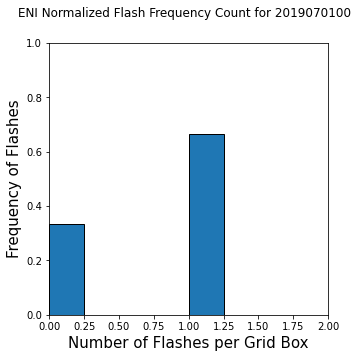

In [26]:
#makehistogram(dfname, dfcolname, binnum, size, minxlim, maxxlim, minylim, maxylim, inst, dtime):
makehistogram(df_flsh234, df_flsh234['ENI flshes'], np.linspace(0, 2, 9, endpoint=True), 5, 0, 2, 0, 1,
              'ENI', '2019070100')

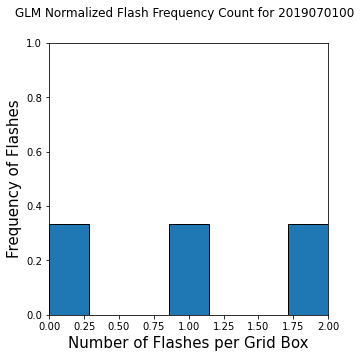

In [27]:
#makehistogram(dfname, dfcolname, binnum, size, minxlim, maxxlim, minylim, maxylim, inst, dtime):
makehistogram(df_flsh234, df_flsh234['GLM flshes'], np.linspace(0, 2, 8, endpoint=True), 5, 0, 2, 0, 1,
             'GLM', '2019070100')

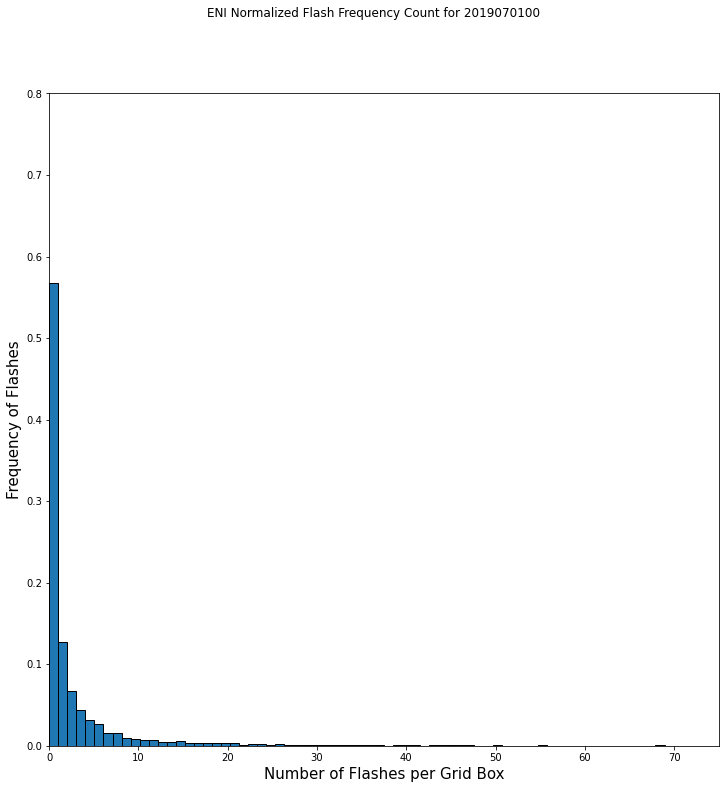

In [28]:
#makehistogram(dfname, dfcolname, binnum, size, minxlim, maxxlim, minylim, maxylim, inst, dtime):
makehistogram(df_flsh, df_flsh['ENI flshes'], np.linspace(0, 75, 75, endpoint=True), 12, 0, 75, 0, .8,
             'ENI', '2019070100')


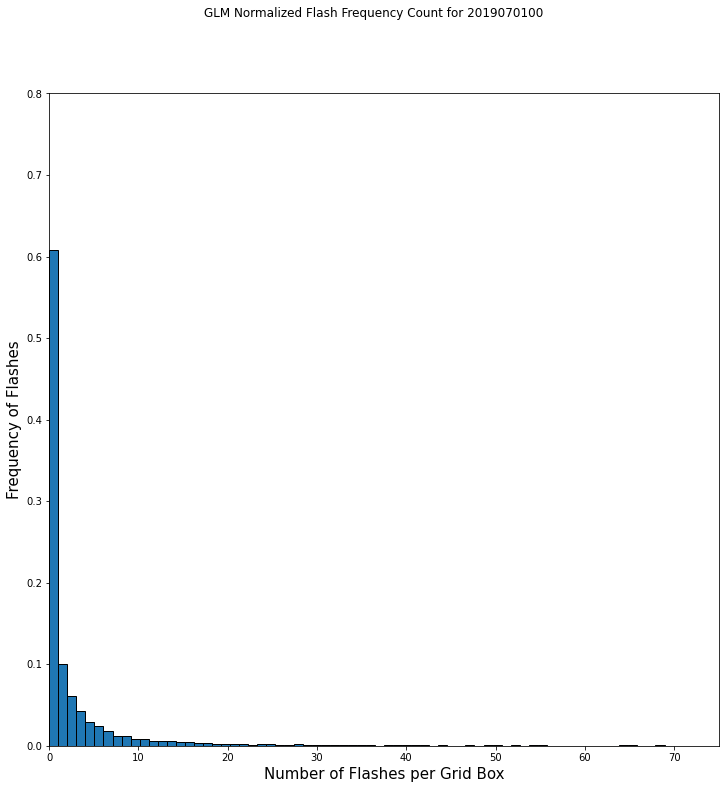

In [29]:
#makehistogram(dfname, dfnamecol, binnum, size, minxlim, maxxlim, minylim, maxylim):
makehistogram(df_flsh, df_flsh['GLM flshes'], np.linspace(0, 75, 75, endpoint=True), 12, 0, 75, 0, .8,
             'GLM', '2019070100')

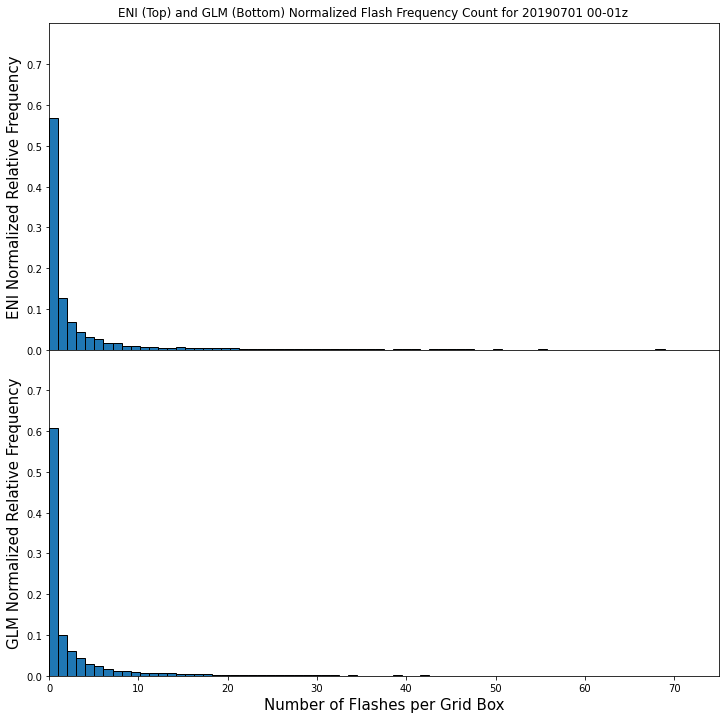

In [30]:
#create stacked histograms of ENI and GLM data from 'makestackedhistogram' function for range below 75
#makestackedhistogram(dfname, col1, col2, binnum, size, xlim[min,max], maxy, yinter, name)
#to save change last parameter from '-' to 'fullgrid_2019070100z_histogram_below75.png'
makestackedhistogram(df_flsh, 'ENI flshes', 'GLM flshes', np.linspace(0, 75, 75, endpoint=True), 12, [0,75], 0.8, .1,
                     '-')

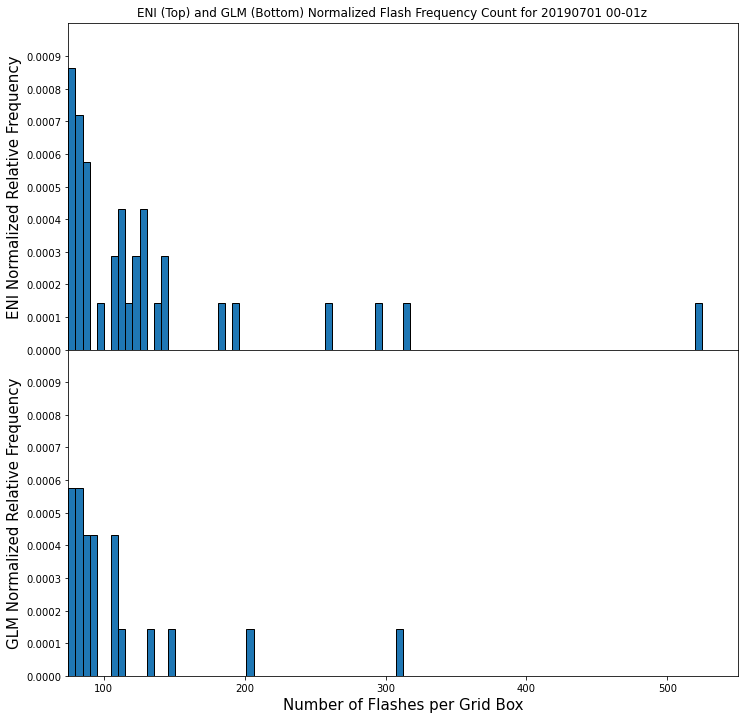

In [31]:
#create stacked histograms of ENI and GLM data from 'makestackedhistogram' function for range above 75
#makestackedhistogram(dfname, col1, col2, binnum, size, xlim[min,max], maxy, yinter, name)
#to save change last parameter from '-' to 'fullgrid_2019070100z_histogram_above75.png'
makestackedhistogram(df_flsh, 'ENI flshes', 'GLM flshes', np.linspace(75, 550, 95, endpoint=True), 
                     12, [75,550], 0.001, 0.0001, '-')


## Scatter<a class="anchor" id="Scatter"></a>

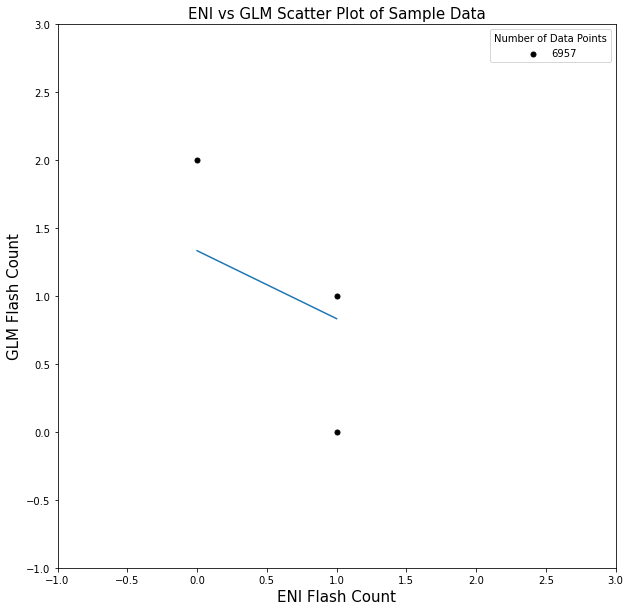

In [32]:
# x and y values are squared as the function makes use of a 
# squareroot axes 
makescattersample(df_flsh234['ENI flshes'], df_flsh234['GLM flshes'], True, -1, 3)

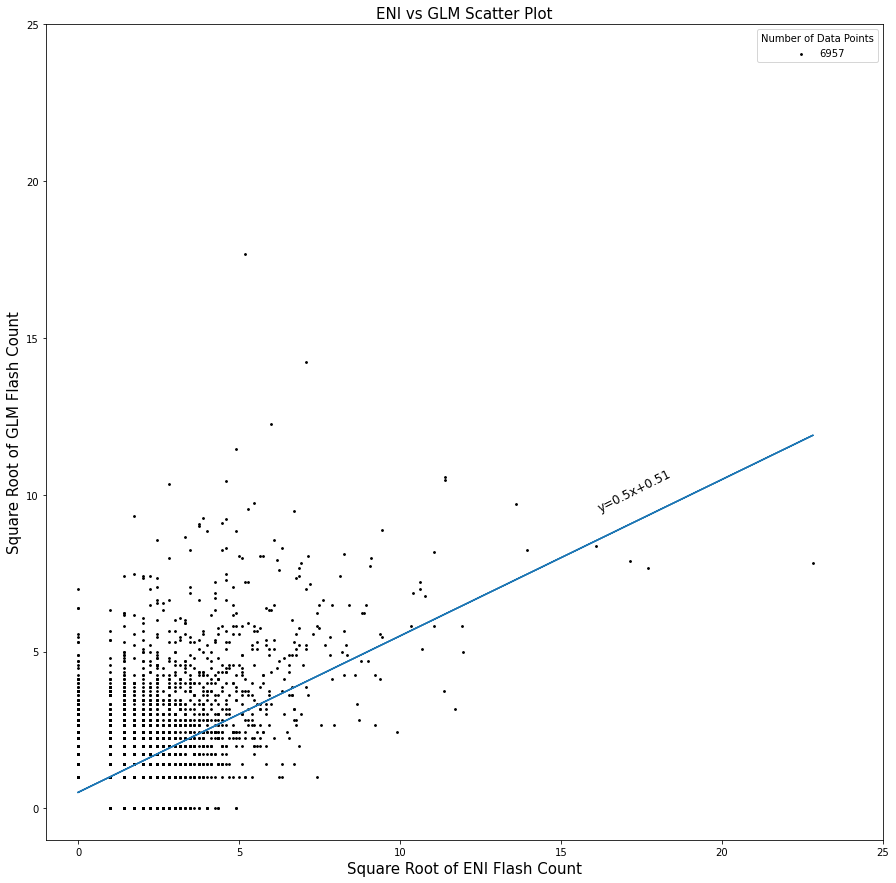

In [33]:

makescatter(df_flsh['ENI flshes'], df_flsh['GLM flshes'], True, -1, 25, '-')

# Stats and Visualization for Larger Datasets<a class="anchor" id="Larger Datasets"></a>

In [3]:
dfallhrs = pd.read_csv('EN-GLM_gridded-flash-count_201907_01-31_all-hours.txt.txt',
        names=['datetime', 'i coords','j coords','ENI flshes','GLM flshes'], delimiter='\s+')

NameError: name 'pd' is not defined

In [25]:
#dfallhrs

In [26]:
#Make image with scatter plots for 10 random days 
#makemultiplescatter(dfname1, dfname2, dates, regress, minlim, maxlim, name)

In [95]:
dates = generaterandomdates('2019', '07', '00', 12, 31)
dates

['2019070400',
 '2019070600',
 '2019070800',
 '2019070900',
 '2019071000',
 '2019071100',
 '2019071200',
 '2019071400',
 '2019071700',
 '2019071800',
 '2019072500',
 '2019072600']

In [96]:
dftry1 = generatedtdframes(dfallhrs, dates[0:4])
dftry2 = generatedtdframes(dfallhrs, dates[4:8])
dftry3 = generatedtdframes(dfallhrs, dates[8:12])

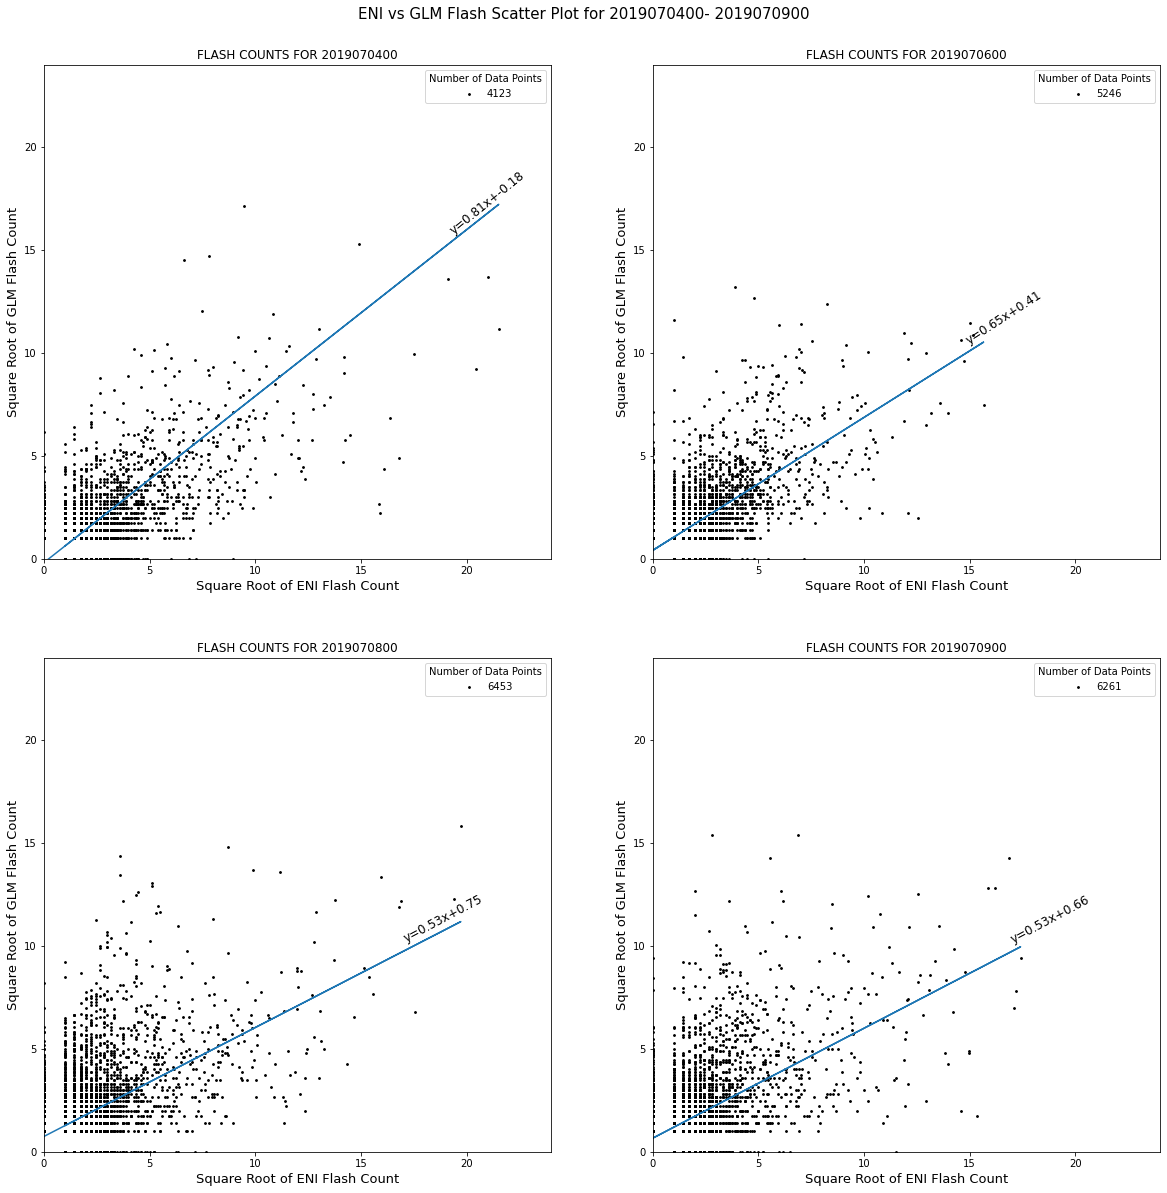

In [97]:
makemultiplescatter(dftry1, dates[0:4], 20, 24, "-")

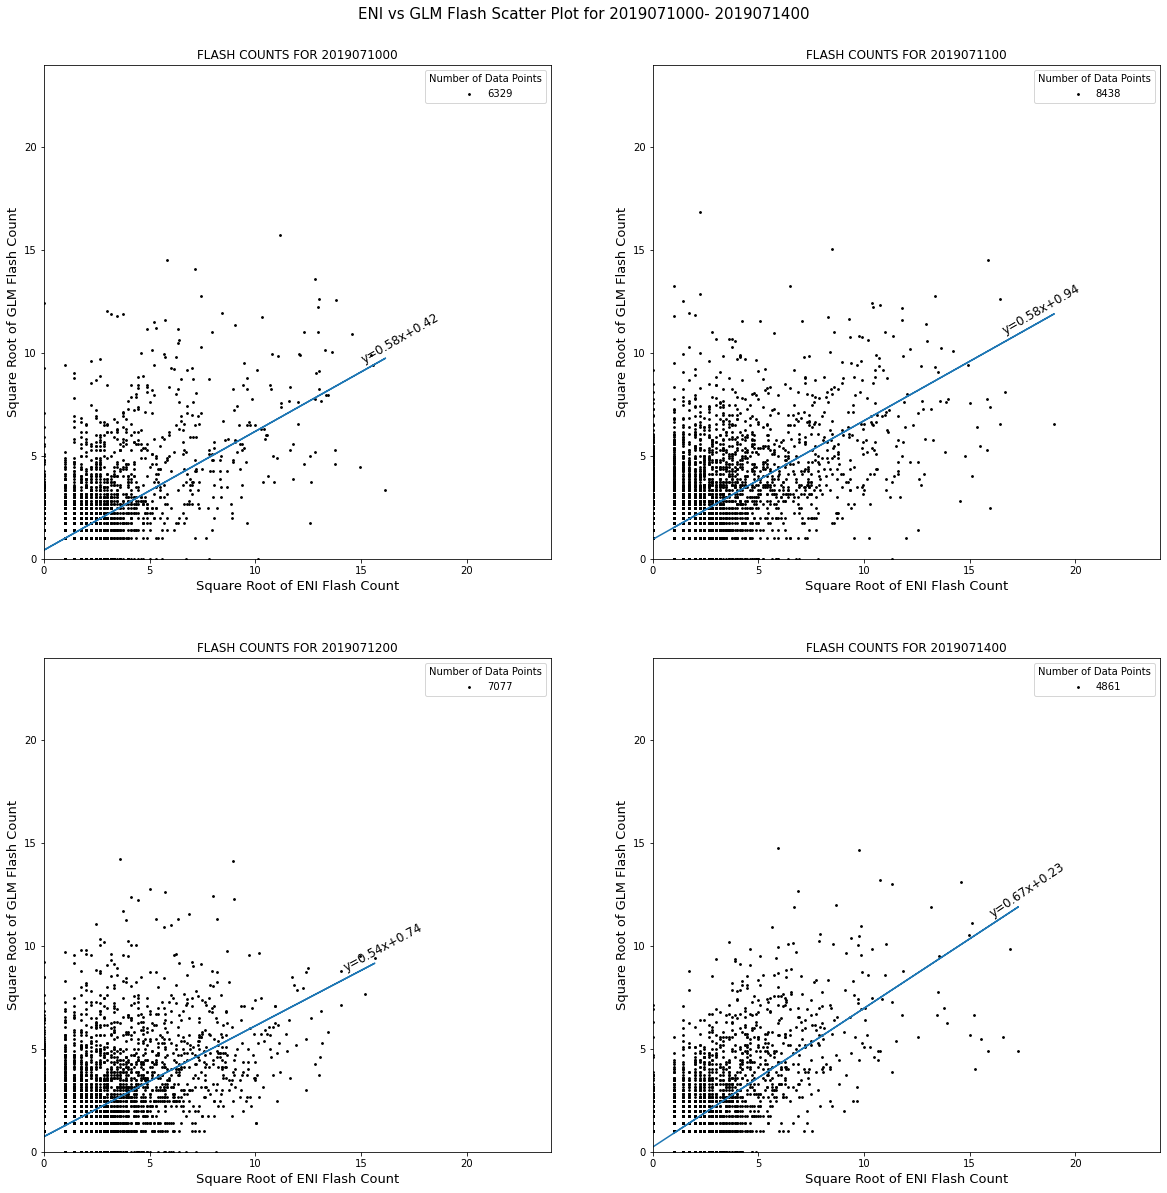

In [98]:
makemultiplescatter(dftry2, dates[4:8], 20, 24, "-")
#July 16 & 19 no GLM flashes

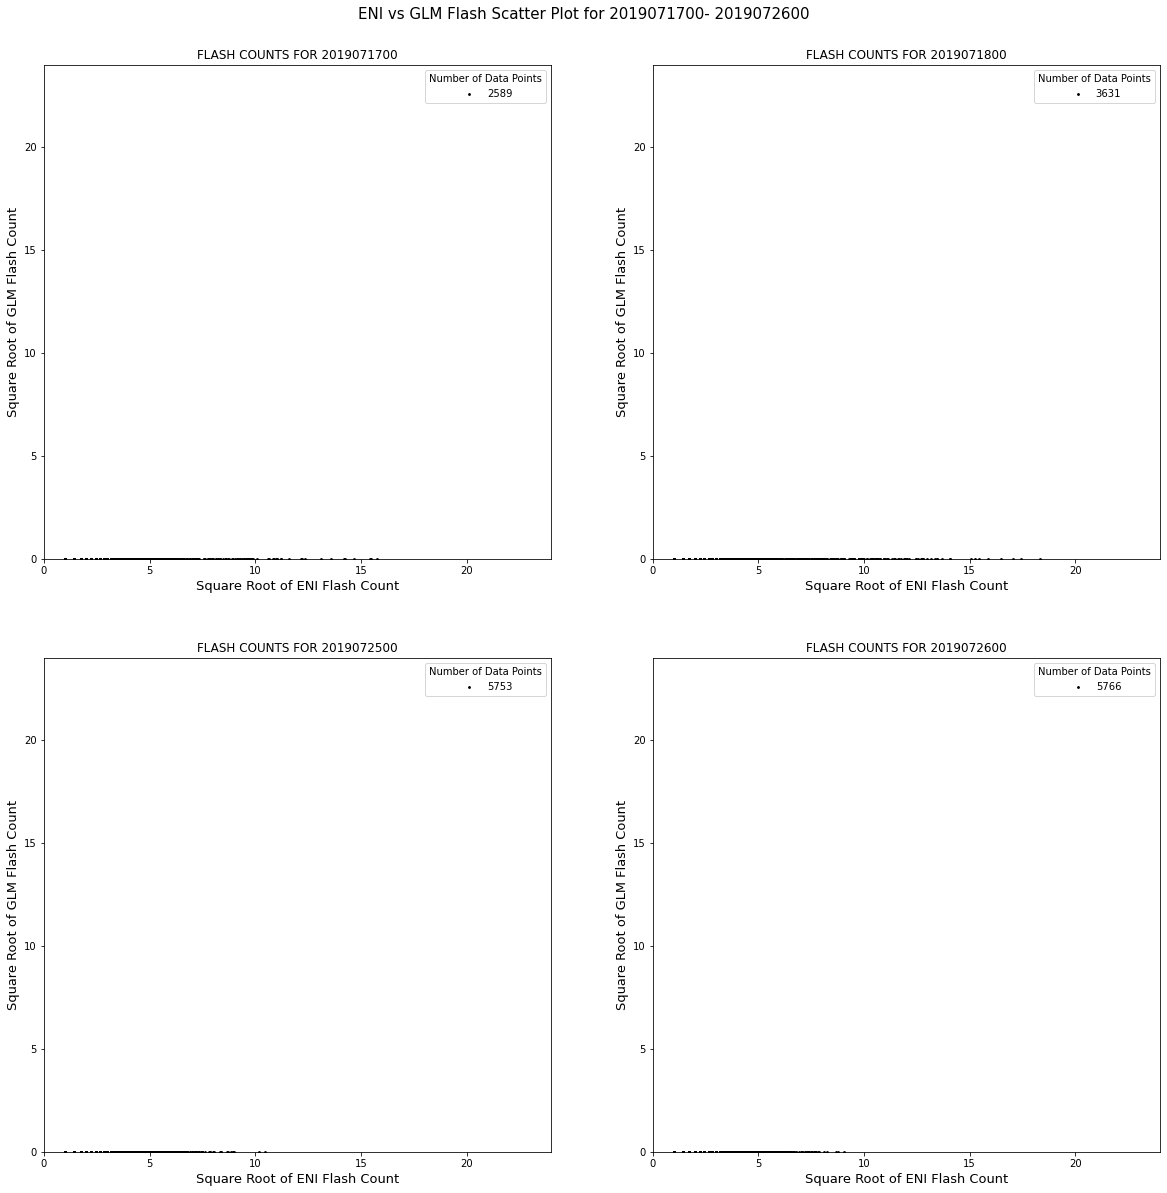

In [99]:
makemultiplescatter(dftry3, dates[8:12], 20, 24, "-")

In [29]:
alldaysJul = generatedates('2019', '07', '22', '01', '31')
#alldaysJul

In [30]:
July_df = generatedtdframes(dfallhrs, alldaysJul)
#July_df

In [31]:
#allJuldata= dfallhrs.loc[dfallhrs['datetime'] >= alldaysJul[0]].loc[dfallhrs['datetime'] <= alldaysJul[-1]]
allJuldata = pd.concat(July_df)
#allJuldata

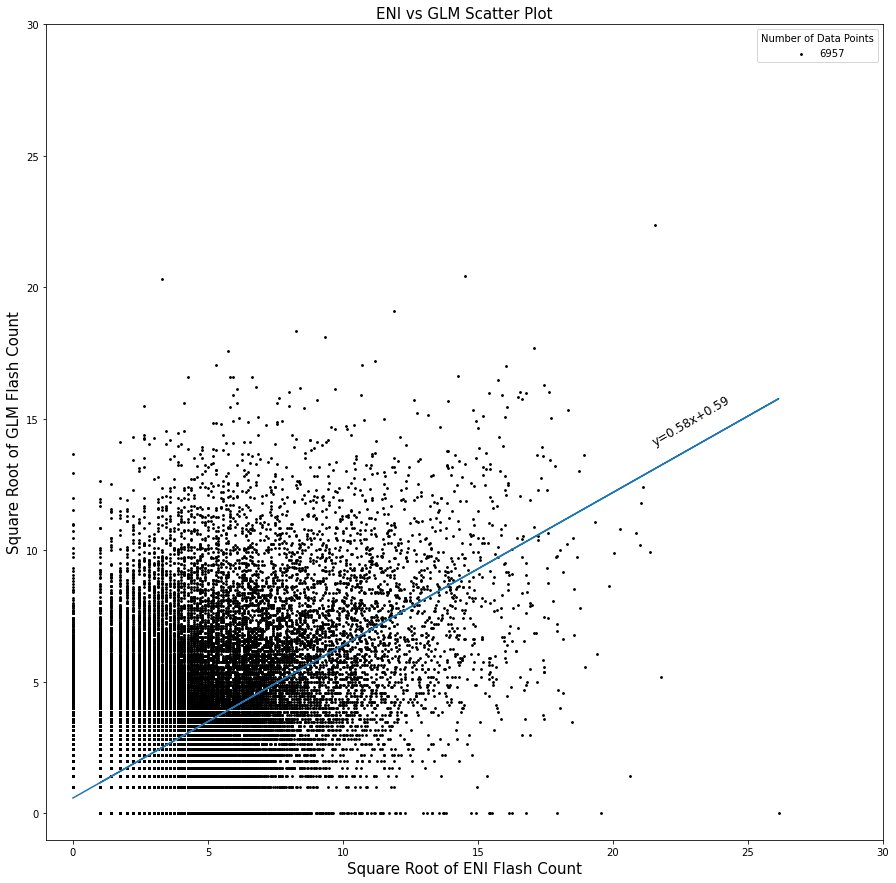

In [114]:
#makescatter(dfname1, dfname2, dfname3, minlim, maxlim, name)
makescatter(allJuldata['ENI flshes'], allJuldata['GLM flshes'], -1, 30, 'full grid_totalscatter_2019070122z')

In [59]:
savemultiscatter(July_df, alldaysJul, 15)

26.0
creating figure for:2019070122
saving figure for:2019070122
creating figure for:2019070222
saving figure for:2019070222
creating figure for:2019070322
saving figure for:2019070322
creating figure for:2019070422
saving figure for:2019070422
creating figure for:2019070522
saving figure for:2019070522
creating figure for:2019070622
saving figure for:2019070622
creating figure for:2019070722
saving figure for:2019070722
creating figure for:2019070822
saving figure for:2019070822
creating figure for:2019070922
saving figure for:2019070922
creating figure for:2019071022
saving figure for:2019071022
creating figure for:2019071122
saving figure for:2019071122
creating figure for:2019071222
saving figure for:2019071222
creating figure for:2019071322
saving figure for:2019071322
creating figure for:2019071422
saving figure for:2019071422
creating figure for:2019071522
saving figure for:2019071522
creating figure for:2019071622
saving figure for:2019071622
creating figure for:2019071722
savi

In [33]:
savenosqrtmultiscatter(July_df,  alldaysJul, 15)

683.0
creating figure for:2019070122
saving figure for:2019070122
creating figure for:2019070222
saving figure for:2019070222
creating figure for:2019070322
saving figure for:2019070322
creating figure for:2019070422
saving figure for:2019070422
creating figure for:2019070522
saving figure for:2019070522
creating figure for:2019070622
saving figure for:2019070622
creating figure for:2019070722
saving figure for:2019070722
creating figure for:2019070822
saving figure for:2019070822
creating figure for:2019070922
saving figure for:2019070922
creating figure for:2019071022
saving figure for:2019071022
creating figure for:2019071122
saving figure for:2019071122
creating figure for:2019071222
saving figure for:2019071222
creating figure for:2019071322
saving figure for:2019071322
creating figure for:2019071422
saving figure for:2019071422
creating figure for:2019071522
saving figure for:2019071522
creating figure for:2019071622
saving figure for:2019071622
creating figure for:2019071722
sav

In [34]:
July_nonzeros, nonzerodaysJul = getnonzeros(July_df, alldaysJul)
#July_nonzeros
#nonzerodaysJul

In [35]:
savemultiscatter(July_nonzeros, nonzerodaysJul, 15)

22.0
creating figure for:2019070122
saving figure for:2019070122
creating figure for:2019070222
saving figure for:2019070222
creating figure for:2019070322
saving figure for:2019070322
creating figure for:2019070422
saving figure for:2019070422
creating figure for:2019070522
saving figure for:2019070522
creating figure for:2019070622
saving figure for:2019070622
creating figure for:2019070722
saving figure for:2019070722
creating figure for:2019070822
saving figure for:2019070822
creating figure for:2019070922
saving figure for:2019070922
creating figure for:2019071022
saving figure for:2019071022
creating figure for:2019071122
saving figure for:2019071122
creating figure for:2019071222
saving figure for:2019071222
creating figure for:2019071322
saving figure for:2019071322
creating figure for:2019071422
saving figure for:2019071422
creating figure for:2019071522
saving figure for:2019071522
creating figure for:2019071622
saving figure for:2019071622
creating figure for:2019071722
savi

In [35]:
savenosqrtmultiscatter(July_nonzeros, nonzerodaysJul, 15)

500.0
creating figure for:2019070122
saving figure for:2019070122
creating figure for:2019070222
saving figure for:2019070222
creating figure for:2019070322
saving figure for:2019070322
creating figure for:2019070422
saving figure for:2019070422
creating figure for:2019070522
saving figure for:2019070522
creating figure for:2019070622
saving figure for:2019070622
creating figure for:2019070722
saving figure for:2019070722
creating figure for:2019070822
saving figure for:2019070822
creating figure for:2019070922
saving figure for:2019070922
creating figure for:2019071022
saving figure for:2019071022
creating figure for:2019071122
saving figure for:2019071122
creating figure for:2019071222
saving figure for:2019071222
creating figure for:2019071322
saving figure for:2019071322
creating figure for:2019071422
saving figure for:2019071422
creating figure for:2019071522
saving figure for:2019071522
creating figure for:2019071622
saving figure for:2019071622
creating figure for:2019071722
sav

In [217]:
t_p = getmultitpvals(July_df, alldaysJul)
tott, totp = gettpvalues(allJuldata)
new_row = {'Date':'Total', 't Value':tott, 'p Value':totp}
t_p = t_p.append(new_row, ignore_index=True)
t_p
t_p.to_csv ('July_tpvalues_bydate.csv', index = False, header=True)


In [2]:
boxwhis(July_df, alldaysJul, 15)

NameError: name 'July_df' is not defined

# Testing area for coding (will delete later)

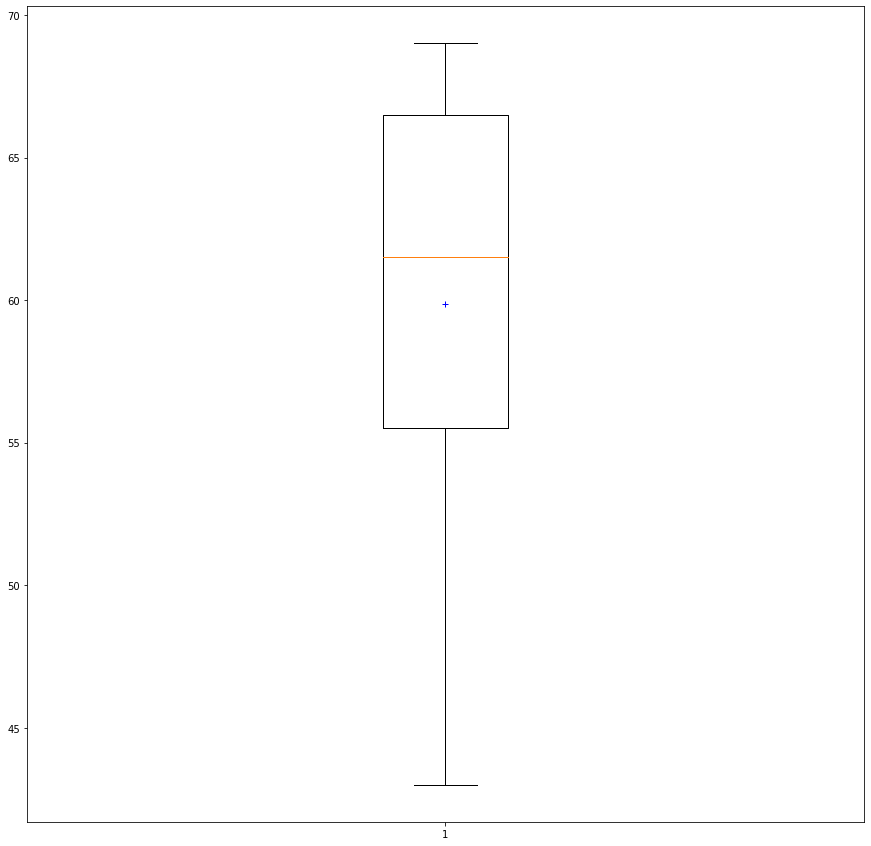

In [62]:
ex = [43,54,56,61,62,66,68, 69]#,69,70,71,72,77]#78,79,85,87,88,89,93,95,96,98,99,99]
fig = plt.figure(figsize=(15,15))
meanpointprops = dict(marker='+', markeredgecolor='blue',
                      markerfacecolor='blue')
info = plt.boxplot(ex, showmeans=True, meanprops=meanpointprops)
plt.show(info)

In [54]:
info
upper = info['boxes'][0].get_ydata()[1]


array([55.5, 55.5, 66.5, 66.5, 55.5])

In [65]:
df_flsh

,ENI flshes,GLM flshes
0,0.0,13.0
1,0.0,2.0
2,1.0,1.0
3,1.0,0.0
4,0.0,2.0
5,0.0,5.0
6,0.0,1.0
7,0.0,1.0
8,0.0,16.0
9,0.0,3.0


In [70]:
stats.sem(df_flsh, axis=None)

0.10003308069553439

In [89]:
import inspect as i
import sys
print(i.getsource(stats.sem))
#stats.sem

def sem(a, axis=0, ddof=1, nan_policy='propagate'):
    """
    Compute standard error of the mean.

    Calculate the standard error of the mean (or standard error of
    measurement) of the values in the input array.

    Parameters
    ----------
    a : array_like
        An array containing the values for which the standard error is
        returned.
    axis : int or None, optional
        Axis along which to operate. Default is 0. If None, compute over
        the whole array `a`.
    ddof : int, optional
        Delta degrees-of-freedom. How many degrees of freedom to adjust
        for bias in limited samples relative to the population estimate
        of variance. Defaults to 1.
    nan_policy : {'propagate', 'raise', 'omit'}, optional
        Defines how to handle when input contains nan.
        The following options are available (default is 'propagate'):

          * 'propagate': returns nan
          * 'raise': throws an error
          * 'omit': performs the calculation

In [101]:
results = stats.linregress(df_flsh['ENI flshes'], df_flsh['GLM flshes'])

In [102]:
results 

LinregressResult(slope=0.36152179640039245, intercept=2.201784883078735, rvalue=0.480151373897199, pvalue=0.0, stderr=0.007919527293091054)

In [116]:
stats.linregress?

In [121]:
# sqrt [ Σ(yi - ŷi)2 / (n - 2) ] / sqrt [ Σ(xi - x)2 ]
xmean = getmean(df_flsh['ENI flshes'])
ymean = getmean(df_flsh['GLM flshes'])
n = len(df_flsh['ENI flshes'])
se=np.sqrt(sum((df_flsh['GLM flshes']-ymean)**2)/(n-2))/np.sqrt(sum((df_flsh['ENI flshes']-xmean)**2))
slope = getslope(df_flsh['ENI flshes'], df_flsh['GLM flshes'])
df=n-2
t=slope/se
print(slope)
print(se)
print(getrcoor(df_flsh['ENI flshes'], df_flsh['GLM flshes']))
print(getintercept(df_flsh['ENI flshes'], df_flsh['GLM flshes']))

0.6377080003221344
0.009028336619661462
0.4801513738971998
1.0241526345327308


# Formulas<a class="anchor" id="Formulas"></a>

## Standard Deviation

##### Note a function rather than the coded equation was used to obtain the standard deviation <br> however the typical formula for performing such computations is below

#### Equation typically used to compute std:

\begin{equation*}
s = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})^2}
\end{equation*}

##### Where <br> n is the number of numbers, ${x_i}$ is the i-th number in the list, $\bar{x}$ is the sample mean
##### Also note that python uses a divisor of "N - ddof" where ddof is the "Delta degrees of Freedom." The equation is normalized by "N-1" <br> by default. We keep this convention as we are computing the standard deviaton of the sample

## Mean Absolute Difference

#### Equation used to compute MAD:

\begin{equation*}
MAD = \frac{1}{n}\sum_{i=1}^{n} |x_i - y_i|
\end{equation*}

##### Where <br> n is the number of numbers, ${x_i}$ is the i-th x value in the list, ${y_i}$ is the i-th y value in the list

## Root Mean Square Difference

#### Equation used to compute RMS:

\begin{equation*}
RMSD = \sqrt{\frac{1}{n}\sum_{i=1}^{n} |x_i - y_i|^2}
\end{equation*}

##### Where <br> n is the number of numbers, ${x_i}$ is the i-th x value in the list, ${y_i}$ is the i-th y value in the list

## Percentiles

#### Steps used to compute the kth percentile:

\begin{equation*}
1.\frac{k}{100}*n 
\end{equation*}

